# Mode Connectivity of Neural Networks (Part 1)

<br>

## Intro to the Problem
<br>
Consider a neural network with parameters $\theta \in \mathbb{R}^D$ and function $f(\theta): \mathbb{R}^D \rightarrow \mathbb{R}$ which evaluates the error/loss of the network with given set of parameters. In this view, optimization landscape is a surface defined by $(\theta, f(\theta))$ for all $\theta \in \mathbb{R}^D$.

The optimization landscape for non-convex problems, such as neural network training, typically exhibits many poor local optima and is challenging for optimization algorithms. In this project we investigate an interesting phenomenon  first described in line of works by Garipov & Draxler, called **mode connectivity**. In particular, it was shown that solutions found by SGD for large network are not isolated points in the parameter space, but rather connected via continous path on which the value of risk does not differ much from the end points.

<img src="ileyeofcgjsdc52q3jildv6alkk.jpeg" alt="Drawing" style="width: 400px;"/>
<br>
<center> Fig. 1: An example of optimization landscape of non-convex problem<center>

Notably, a simple linear interpolation between the solutions is not enough and the path ought to be constructed in more intelligent fashion. In this part of the project we imprement an algorithm from **"Loss Surfaces, Mode Connectivity, and Fast Ensembling of DNNs"** by Timur Garipov et al., to find a suitable path between two solutions found by an optimization algorithm.

## Network Training on MNIST

<br>

First things first, we would need to get these two solutions. In this project we consider training a simple two-layer fully connected network for the MNIST classification task, i.e., neural network should be able to assign a correct class to the input digit image.

<img src="two-layer.png" alt="Drawing" style="width: 400px;"/>
<br>
<center> Fig. 2: Schematic illustration of two-layer neural network<center>
<br>
    
To train a network and for further path construction manipulations we will rely on the Automatic Differentiation package called PyTorch, as it is relatively user-friendly and provides with all tools we would need.

In [5]:
# importing all necessary packages

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Minimal working examples

In this section, we will try to cover the basic logics of PyTorch framework. In a nutshell, it allows to compute the derivatives for any $f : \mathbb{R}^d \rightarrow \mathbb{R}$ w.r.t. the input $x \in \mathbb{R}^d$. The input $x$ should be either `torch.Tensor` for which `requires_grad=True` or `torch.nn.Parameter`. To illustrate consider

$$
f(x) = x_1^2 + 2 x_1 x_2 + x_2^2, \quad x \in \mathbb{R}^2
$$

thus the derivatives w.r.t. $x$ can be computed as follows 

$$
\frac{\partial f}{\partial x_1} = 2 x_1 + 2 x_2, \quad \frac{\partial f}{\partial x_2} = 2 x_2 + 2 x_1
$$

Now let us check if PyTorch would give us a proper answer.

In [7]:
x = torch.tensor([1., 1.], requires_grad = True)  # we want derivative of f w.r.t. x in point where x = (1,1)
f = x[0] ** 2 + 2 * x[0] * x[1] + x[1] ** 2  # define a function value at point x = (1,1)
f.backward()  # computes a gradient w.r.t x which is stored in x.grad field
print(x.grad)

tensor([4., 4.])


Text(0.5, 1.0, 'f(x1,x2) = (x1+x2)^2')

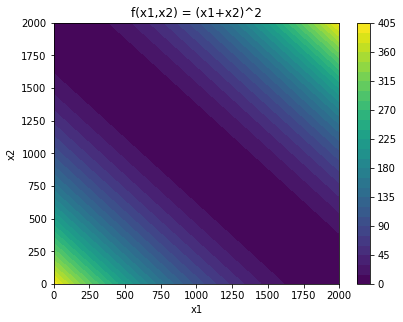

In [8]:
#(SREYAM) Contour plot:
X = np.arange(-10,10.01,0.01)
Y = np.arange(-10,10.01,0.01)

X,Y = np.meshgrid(X,Y)
Z = X**2 + 2*X*Y + Y**2

fig, ax = plt.subplots(1,1,figsize=(6.4,4.8))

img = ax.contourf(Z, levels=30)
fig.colorbar(img)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("f(x1,x2) = (x1+x2)^2")
# fig.savefig("Fitness landscape.jpg",bbox_inches = "tight")

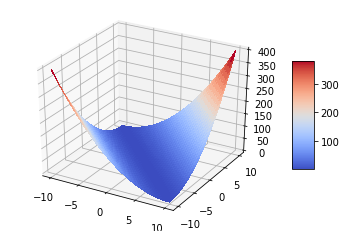

In [9]:
#(SREYAM) 3D plot:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-10,10.1,0.1)
Y = np.arange(-10,10.1,0.1)
X,Y = np.meshgrid(X,Y)
Z = X**2 + 2*X*Y + Y**2

# Plot the surface.
surf = ax.plot_surface(X,Y,Z,cmap=cm.coolwarm,linewidth=0,antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

As one can see the output is correct since for both coordinates

$$
\frac{\partial f}{\partial x_1}(1,1) = 2 x_1 + 2 x_2 = 2 \cdot 1 + 2 \cdot 1 = \quad \frac{\partial f}{\partial x_2}(1,1).
$$

With this in mind we can now try to implement a steapest descent to find a minimum of function $f$. Note that the global minimum is obviously allocated at point any point where $x_1 = - x_2$ since $f(x) = (x_1 + x_2)^2$. 
<br>

Fortunately, many steepest descent procedures are already implemented in `torch.optim`, we will use a simple one - Gradient Descent (GD). At each step we compute the gradient at current point and then make a step in the opposite direction with some "learning rate" $\alpha$, formally

$$
x^{(t + 1)} = x^{(t)} - \alpha \cdot \nabla f(x^{(t)}).
$$

We can continue this procedure until convergence or just fixing a maximum amount of iterations we should perform. The example code could be found below.

In [10]:
x = torch.tensor([1., 1.], requires_grad = True) # initialize a starting point for GD

optimizer = optim.SGD([x], lr=1e-1) # define optimizer first argument is a list of variables over which
# we want to optimize, lr = learning rate. HYPERPARAMETER 1.

for it in range(100): # 100 is the number of GD iterations we set
    f = x.sum().pow(2) # for each x^t we compute the corresponding value of f to get gradient after
    # x.sum().pow(2) gives the same result as x[0] ** 2 + 2 * x[0] * x[1] + x[1] ** 2
    f.backward() # get the gradient at current point
    optimizer.step() # make one optimization step
    optimizer.zero_grad() # sets the field x.grad to zero, since otherwise on next backward 
    # the gradient would be added to the previous value -> would be wrong (i.e., grads are
    # stored always by default unless you zero them down) 
    
print(x) # get the value of x after 100 iterations

tensor([6.5332e-23, 6.5332e-23], requires_grad=True)


What went wrong? Why did we end up in a point which is approximately $(0,0)$? The answer is: GD procedure can find any stationary point, i.e., where $\nabla f(x) = 0$. One can check that $(0,0)$ is indeed one but not a global minimum! How can we cure this? Simply by trying more initial points and picking the one which gives the best value of $f$. However since we know that in global minimum $x_1 = - x_2$ we can cheat and initialize for instance with $x=(2,-1)$ (to not get stuck at bad (0,0) point).

In [11]:
x = torch.tensor([2., -1.], requires_grad = True) # cheating

optimizer = optim.SGD([x], lr=1e-1)

for it in range(100):
    f = x.sum().pow(2)
    f.backward()
    optimizer.step()
    optimizer.zero_grad()
    
print(x)

tensor([ 1.5000, -1.5000], requires_grad=True)


Now everying is perfect since we found a point where $x_1 = -x_2$. 


##### Neural Network Training Outline

Now consider a more complicated optimization procedure – neural network training. Although we will cover each step thoroughly in next section, in nutshell it can be described as follows:

<br>
Now we have a complicated function (NN) $f_{\theta}(x)$ which depends on weights $\theta$ and input $x$. We will focus only on classification. Consider a data $(x,y)$ ($x$ is input and $y$ is correct label for current $x$) which comes from some distribution $\mathcal{D}$. And assume we have a measure of how good network prediction $f_{\theta}(x)$ is compared to true $y$ - we call it $\mathcal{L}(\cdot, \cdot)$. In this view, we want to find a parameters $\theta$ which minimize the expected loss

$$
\mathbb{E}_{(x,y) \sim \mathcal{D}} \mathcal{L}(f_{\theta}(x), y),
$$

we can do so by sampling a subset of examples from $\mathcal{D}$ of size $B$, i.e., $\{(x_i,y_i)\}_{i=1}^B \sim \mathcal{D}^B$ on each step and computing a gradient of

$$
\frac{1}{B} \sum_{i=1}^M \mathcal{L}(f_{\theta}(x_i), y_i)
$$

w.r.t. $\theta$ and update $\theta$ with gradient step.

### Network Definition and Training

#### Step 1: Dataset

First we download the dataset and normalize each image for optimization stability. `train_loader` and `test_loader` are iterators for corresponding parts of the dataset.

In [12]:
# convert image to tensor for PyTorch, and normalize with mean and std for stability
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

# downloading training and test parts of MNIST dataset
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)

# get train and test samplers with B=100 for train and B=1000 for test
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000, shuffle=False)

Below you can see the sample images from the dataset.

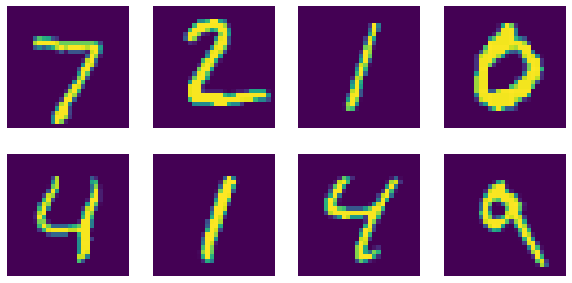

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10,5))

data = next(iter(test_loader))[0][:8]
for i in range(8):
    ax[i // 4][i % 4].imshow(data[i].numpy()[0,:,:])
    ax[i // 4][i % 4].axis('off')
plt.show()

#### Step 2: Network Definition

For this task we will train a two-layer network with 500 hidden units. Since each MNIST image has size $28 \times 28$ first linear layer has shape $(28 \cdot 28) \times 500$. As the number of classes for digits is equal to $10$ final layer has shape $500 \times 10$. As an activation function we will use Rectified Linear Unit (`nn.ReLU`). **The network outputs the vector of size 10 which corresponds to probability of each class**.


**Task1:** Implement a forward pass for this network which consists of

$$
\textrm{input} \rightarrow \textrm{Linear layer 1} \rightarrow \textrm{ReLU} \rightarrow \textrm{Linear layer 2}
$$

in corresponding function. Each layer or activation output on input $x$ can be obtained calling

$$
\textrm{layer/act}(x)
$$

The forward pass for the model on input is called in the same fashion.

In [14]:
#(SREYAM) To see how the class and objects work in Python:
class Circle:
    def __init__(self,radius):
        self.radius = radius        
    def area(self):
        return np.pi*(self.radius)**2    
    def circum(self):
        return 2*np.pi*self.radius

c1 = Circle(10)
print(f"Area of circle (radius 10): {round(c1.area(),4)}")
print(f"Circumference of circle (radius 10): {round(c1.circum(),2)}")
print()

c2 = Circle(0.1)
print(f"Area of circle (radius 0.1): {round(c2.area(),8)}")
print(f"Circumference of circle (radius 0.1): {round(c2.circum(),4)}")

Area of circle (radius 10): 314.1593
Circumference of circle (radius 10): 62.83

Area of circle (radius 0.1): 0.03141593
Circumference of circle (radius 0.1): 0.6283


In [15]:
class FCN(nn.Module):
    
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 500)
        self.fc2 = nn.Linear(500, 10)
        self.act = nn.ReLU()
        
    def forward(self, x):
        output = self.fc1(x)
        output = self.act(output)
        output = self.fc2(output)
        return output

All network parameters can be accessed via `.parameters()` method.

#### Step 3: Training Epoch

For classification task we will use $\mathcal{L}$ which is cross-entropy loss. It can be accessed by calling `F.cross_entropy(output, target)`, where `output` is the result of forward pass through the model and `target` are true labels.

**Task1:**
In cell bellow implement one step of optimization proceedure:

*1)* Obtain output for current subset of dataset, i.e., `data`

*2)* Compute loss objective on current `output` and `target`

*3)* Compute the gradient update and make a step

**Task2:** In addition, it is helpful to see that the loss is decreasing during iterations. Thus, implement progress tracker which will print the loss value periodically (say each 60 steps <=> `batch_idx % 60 == 0` ).


In [16]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader): # sample subset of dataset - (x,y)
        data = data.view(-1,28 * 28) # reshape 2d image to vector of size 28x28
        target = target
        # => Implement a computation of gradient for current batch of data
        optimizer.zero_grad()
        output=model(data)
        loss = F.cross_entropy(output, target)  
        loss.backward()
        optimizer.step()
        # => Implement progress tracker
        if batch_idx % 60 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, 15, batch_idx, len(train_loader), loss.item()))

#### Step 4: Test epoch

As model is trained on the training part of the dataset a good performance measurement is to track loss and accuracy

$$
\textrm{accuracy(output, target)} =  \mathbb{I}\{\arg\max_{i}\textrm{output}_i = target\},
$$

i.e., if max probability is assigned to a correct class, which model achieves on a test part of the dataset which it did not see.


**Task 1:** Compute the loss objective and accuracy averaged over the whole test dataset. Print it and return average test loss value as function output.

In [17]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # to not store the gradients (i.e., ease memory requirement)
        #correct = 0
        total = 0
        for data, target in test_loader:
            data = data.view(-1,28 * 28)
            target = target
            output = model(data)
            test_loss = F.cross_entropy(output, target)
#             optimizer.zero_grad()
#             test_loss.backward()
#             optimizer.step()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        print('Accuracy of the network on the 1000 test images: {} %'.format(100 * correct / total))
    return test_loss
    # ===> Implement progress tracker

#### Step 5:  Train two networks for connectivity experiments

Now we have both training and test functions in our hands. Train function implements one pass over the whole dataset.

**Task 1:** Train first network to test accuracy around **97-98%**.

*1)* Define optimizer over network parameters with some learning rate.

*2) (optional)* For better results use `StepLR` (step learning rate) to decay learning rate after each epoch

*3)* After each training call in loop call test function to see resulting model performance

*4)* Number of epochs (i.e., train calls) is up to you, but around 15 should be enough

In [18]:
model = FCN()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-2, momentum=0.9)
# ===> Implement training

for epoch in range(1, 14 + 1):
    # ===> Train + test step with optional StepLR call
    train(model,train_loader,optimizer,epoch)
    test(model,test_loader)

Epoch [2/15], Step [0/600], Loss: 2.4053
Epoch [2/15], Step [60/600], Loss: 0.9321
Epoch [2/15], Step [120/600], Loss: 0.5996
Epoch [2/15], Step [180/600], Loss: 0.5030
Epoch [2/15], Step [240/600], Loss: 0.4211
Epoch [2/15], Step [300/600], Loss: 0.3562
Epoch [2/15], Step [360/600], Loss: 0.3751
Epoch [2/15], Step [420/600], Loss: 0.2022
Epoch [2/15], Step [480/600], Loss: 0.3374
Epoch [2/15], Step [540/600], Loss: 0.1944
Accuracy of the network on the 1000 test images: 92.46 %
Epoch [3/15], Step [0/600], Loss: 0.2021
Epoch [3/15], Step [60/600], Loss: 0.1675
Epoch [3/15], Step [120/600], Loss: 0.2354
Epoch [3/15], Step [180/600], Loss: 0.2583
Epoch [3/15], Step [240/600], Loss: 0.2730
Epoch [3/15], Step [300/600], Loss: 0.2942
Epoch [3/15], Step [360/600], Loss: 0.1975
Epoch [3/15], Step [420/600], Loss: 0.3110
Epoch [3/15], Step [480/600], Loss: 0.3442
Epoch [3/15], Step [540/600], Loss: 0.2791
Accuracy of the network on the 1000 test images: 94.48 %
Epoch [4/15], Step [0/600], Loss

Here we save this model for later connectivity experiments

In [19]:
model_1 = deepcopy(model)

**Task 2:** Train the second model for path construction.

In [20]:
model = FCN()

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-2, momentum=0.9)
# ===> Implement training

for epoch in range(1, 14 + 1):
    # ===> Train + test step with optional StepLR call
    train(model,train_loader,optimizer,epoch)
    test(model,test_loader)

Epoch [2/15], Step [0/600], Loss: 2.3432
Epoch [2/15], Step [60/600], Loss: 0.8501
Epoch [2/15], Step [120/600], Loss: 0.6897
Epoch [2/15], Step [180/600], Loss: 0.4731
Epoch [2/15], Step [240/600], Loss: 0.3430
Epoch [2/15], Step [300/600], Loss: 0.4973
Epoch [2/15], Step [360/600], Loss: 0.2987
Epoch [2/15], Step [420/600], Loss: 0.2997
Epoch [2/15], Step [480/600], Loss: 0.2752
Epoch [2/15], Step [540/600], Loss: 0.4046
Accuracy of the network on the 1000 test images: 92.46 %
Epoch [3/15], Step [0/600], Loss: 0.1798
Epoch [3/15], Step [60/600], Loss: 0.1702
Epoch [3/15], Step [120/600], Loss: 0.2822
Epoch [3/15], Step [180/600], Loss: 0.2210
Epoch [3/15], Step [240/600], Loss: 0.2032
Epoch [3/15], Step [300/600], Loss: 0.2293
Epoch [3/15], Step [360/600], Loss: 0.2539
Epoch [3/15], Step [420/600], Loss: 0.1789
Epoch [3/15], Step [480/600], Loss: 0.2689
Epoch [3/15], Step [540/600], Loss: 0.1461
Accuracy of the network on the 1000 test images: 94.47 %
Epoch [4/15], Step [0/600], Loss

Saving resulting model for further usage.

In [21]:
model_2 = deepcopy(model)

## Path construction

In this section we will constuct a simple two-segment linear path of low loss between two solutions. The path between network parameters $\theta_1$ and $\theta_2$ has the following parameteric form

$$
\pi(t) = 
\begin{cases} 2((0.5-t)\theta_1 + t\theta), \quad t \in [0,0.5] \\
2(t\theta_2 + (0.5-t)\theta), \quad t \in [0.5,1] 
\end{cases}.
$$

We aim to find $\theta$ such that the value of risk for any $t \in [0,1]$ is small, i.e.,

$$
\mathbb{E}_{(x,y) \sim \mathcal{D}} \mathcal{L}(f_{\pi(t)}(x), y) \leq \max[ \mathbb{E}_{(x,y) \sim \mathcal{D}} \mathcal{L}(f_{\theta_1}(x), y), \mathbb{E}_{(x,y) \sim \mathcal{D}} \mathcal{L}(f_{\theta_2}(x), y)] + \varepsilon,
$$

does not exceed the value of both end network plus some small value. How we can achieve that? The work around is quite simple:

*1)* for each part of training dataset, i.e., `(data, target)` pair from one iteration over `train_loader` sample $t \sim \textrm{Uniform[0,1]}$

*2)* Compute the loss on this pair for network with parameters $\pi(t)$

*3)* Compute derivatives w.r.t. $\theta$ to minimize the loss and make a step of optimizer

*4)* Repeat above proceedure for several epochs




**Technical note:** Due to restrictions of PyTorch we will use `CurveFCN` class below to insert the parameter values from the path in order to allow backpropagation.

In [22]:
class Linear(nn.Module):
    
    def __init__(self, weight, bias):
        super(Linear, self).__init__()
        self.weight = weight
        self.bias = bias
        
    def forward(self, x):
        return F.linear(x, self.weight, self.bias)

class CurveFCN(nn.Module):
    
    def __init__(self, weight_1, bias_1, weight_2, bias_2):
        super(CurveFCN, self).__init__()
        self.fc1 = Linear(weight_1, bias_1)
        self.fc2 = Linear(weight_2, bias_2)
        self.act = nn.ReLU()
        
    def forward(self, x):
        output = self.act(self.fc1(x))
        output = self.fc2(output)
        return output

**Task 1:** Given $\theta_1 = \textrm{start}$, $\theta_2 = \textrm{end}$, $\theta = \textrm{middle}$ and time step 
$t$ implement a function below which returns a new point which corresponds to $\pi(t)$. 


**Note:** Strictly speaking each $\pi(t)$ consists of 4 parameters `(weight_1, bias_1)` for weights and bias term of first linear layer and `(weight_2, bias_2)` for parameters of second. In this function we assume that we get a consistent triplet, e.g., weights of first layer. In next task we will call this function on all triplets.

In [23]:
def get_chain_element(t, start, middle, end):
    # ===> pi(t)
    if (0<=t and t<=0.5):
        return 2*((0.5-t)*start + t*middle)
    elif (0.5<t and t<=1):
        return 2*(t*end + (0.5-t)*middle)  

Below we emplemented a function which outputs a network with parameters sampled from path.

In [24]:
def get_net(t, model_1, model_mid, model_2):

    params_start = list(model_1.parameters())
    params_end = list(model_2.parameters())
    params_middle = model_mid
    
    params = []
    for idx in range(len(params_start)):
        start, middle, end = params_start[idx], params_middle[idx], params_end[idx]
        new_param = get_chain_element(t, start, middle, end)
        params.append(new_param)
    new_model = CurveFCN(*params)
        
    return new_model

**Task 2:** Implement a training algorithm for $\theta$. 

For a certain amount of epochs go through the dataset and on each subset of training dataset sample a timestemp $t$. 

After use `get_net(t, model_1, model_mid, model_2)` to obtain a network model with parameters $\pi(t)$. For which compute a loss on current subset and gradient for optimization step.

**Note:** you are free to tune optimizer parameters and number of epochs.

In [25]:
model_mid = list(FCN().parameters())

optimizer = optim.Adam(model_mid, lr=0.0001, weight_decay=1e-7)

for epoch in range(1, 54 + 1):
    
    for batch_idx, (data, target) in enumerate(train_loader):
        t = torch.rand(1)[0] # sample timestemp
        
        # ===> get model and make an optimization step
        new_model = get_net(t, model_1, model_mid, model_2)
        new_model.train()
        data = data.view(-1,28 * 28) # reshape 2d image to vector of size 28x28
        target = target
        # => Implement a computation of gradient for current batch of data
        optimizer.zero_grad()
        output=new_model(data)
        loss = F.cross_entropy(output, target)  
        loss.backward()
        optimizer.step()
    test(new_model, test_loader)

Accuracy of the network on the 1000 test images: 97.92 %
Accuracy of the network on the 1000 test images: 98.1 %
Accuracy of the network on the 1000 test images: 98.07 %
Accuracy of the network on the 1000 test images: 97.89 %
Accuracy of the network on the 1000 test images: 93.44 %
Accuracy of the network on the 1000 test images: 97.04 %
Accuracy of the network on the 1000 test images: 98.07 %
Accuracy of the network on the 1000 test images: 97.97 %
Accuracy of the network on the 1000 test images: 96.36 %
Accuracy of the network on the 1000 test images: 97.77 %
Accuracy of the network on the 1000 test images: 98.03 %
Accuracy of the network on the 1000 test images: 97.23 %
Accuracy of the network on the 1000 test images: 96.58 %
Accuracy of the network on the 1000 test images: 98.02 %
Accuracy of the network on the 1000 test images: 97.92 %
Accuracy of the network on the 1000 test images: 98.12 %
Accuracy of the network on the 1000 test images: 97.86 %
Accuracy of the network on the 1

**Task 3:** Implement a function which computes test loss for 50 timesteps in $[0,1]$ interval and returns resulting array of losses.

In [26]:
model_mid = deepcopy(model_mid)

In [27]:
def get_path(model_1, model_mid, model_2):
    # => implement
    t = torch.Tensor(np.arange(0,1,0.02))
    Losses = torch.Tensor(np.zeros(50))
    for i in range(50):
        new_model = get_net(t[i], model_1, model_mid, model_2)
        Losses[i] = test(new_model,test_loader)
    return Losses

In [28]:
res = get_path(model_1, model_mid, model_2)

Accuracy of the network on the 1000 test images: 97.94 %
Accuracy of the network on the 1000 test images: 97.93 %
Accuracy of the network on the 1000 test images: 97.97 %
Accuracy of the network on the 1000 test images: 97.98 %
Accuracy of the network on the 1000 test images: 98.02 %
Accuracy of the network on the 1000 test images: 98.04 %
Accuracy of the network on the 1000 test images: 98.08 %
Accuracy of the network on the 1000 test images: 98.12 %
Accuracy of the network on the 1000 test images: 98.12 %
Accuracy of the network on the 1000 test images: 98.11 %
Accuracy of the network on the 1000 test images: 98.1 %
Accuracy of the network on the 1000 test images: 98.11 %
Accuracy of the network on the 1000 test images: 98.1 %
Accuracy of the network on the 1000 test images: 98.08 %
Accuracy of the network on the 1000 test images: 98.08 %
Accuracy of the network on the 1000 test images: 98.07 %
Accuracy of the network on the 1000 test images: 98.08 %
Accuracy of the network on the 10

**Task 4:** To compare our learn path we choose a simple linear interpolation between two points, namely

$$
\pi_{\textrm{linear}}(t) = (1-t)\theta_1 + t \theta_2,\quad t \in [0,1]
$$

Implement it in function `get_linear_element` in similar spirit to `get_chain_element`.

In [29]:
def get_linear_element(t, start, end):
    # ===> pi_linear(t)
    pi_linear = (1-t)*start + t*end
    return pi_linear

In [30]:
def get_linear_net(t, model_1, model_2):

    params_start = list(model_1.parameters())
    params_end = list(model_2.parameters())
    
    params = []
    for idx in range(len(params_start)):
        start, end = params_start[idx], params_end[idx]
        new_param = get_linear_element(t, start, end)
        params.append(new_param)
    new_model = CurveFCN(*params)
        
    return new_model

**Task 5:** Similar to **task 3** implement a function which returns a loss values for 50 timesteps which partition $[0,1]$ interval on equal pieces but for **linear interpolation** (call `get_linear_net`)

In [31]:
#We removed model_mid from the list of arguments below
def get_path_linear(model_1, model_2):  
    # => implement
    t = torch.Tensor(np.arange(0,1,0.02))
    Losses_linear = torch.Tensor(np.zeros(50))
    for i in range(50):
        new_model = get_linear_net(t[i], model_1, model_2)
        Losses_linear[i] = test(new_model,test_loader)
    return Losses_linear

In [32]:
# res_lin = get_path_linear(model_1, model_mid, model_2)
res_lin = get_path_linear(model_1, model_2)

Accuracy of the network on the 1000 test images: 97.94 %
Accuracy of the network on the 1000 test images: 97.93 %
Accuracy of the network on the 1000 test images: 97.89 %
Accuracy of the network on the 1000 test images: 97.85 %
Accuracy of the network on the 1000 test images: 97.85 %
Accuracy of the network on the 1000 test images: 97.87 %
Accuracy of the network on the 1000 test images: 97.85 %
Accuracy of the network on the 1000 test images: 97.79 %
Accuracy of the network on the 1000 test images: 97.76 %
Accuracy of the network on the 1000 test images: 97.72 %
Accuracy of the network on the 1000 test images: 97.63 %
Accuracy of the network on the 1000 test images: 97.52 %
Accuracy of the network on the 1000 test images: 97.46 %
Accuracy of the network on the 1000 test images: 97.33 %
Accuracy of the network on the 1000 test images: 97.19 %
Accuracy of the network on the 1000 test images: 96.97 %
Accuracy of the network on the 1000 test images: 96.8 %
Accuracy of the network on the 1

**Task 6:** Plot loss on linear path and two-segment one on a single plot.

**Hint:** if everything is correct the loss on two-segment one should be significantly smaller than of linear interpolation.

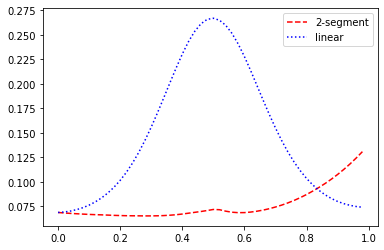

In [33]:
# => plot loss on paths
t = torch.Tensor(np.arange(0,1,0.02))
plt.plot(t,res,'r--',label='2-segment')
plt.plot(t,res_lin,'b:',label='linear')
plt.legend(loc='best')
plt.savefig("losses2Methods.jpg")

### (Bonus part) 

Try to get similar results for the path defined by the **Bezier curve**. It has the following parametric form

$$
\pi(t) = (1-t^2)\theta_1 + t^2 \theta_2 + 2t(1-t) \theta, \quad t \in [0,1],
$$

$\theta$ is parameter which needs to be trained to get a path of low loss.

In [34]:
# => implementation follows
def get_bezier_element(t, start, middle, end):
    # ===> pi_bezier(t)
    pi_bezier = (1-(t**2))*start + (t**2)*end + 2*t*(1-t)*middle
    return pi_bezier

In [35]:
def get_net_bezier(t, model_1, model_mid, model_2):

    params_start = list(model_1.parameters())
    params_end = list(model_2.parameters())
    params_middle = model_mid
    
    params = []
    for idx in range(len(params_start)):
        start, middle, end = params_start[idx], params_middle[idx], params_end[idx]
        new_param = get_bezier_element(t, start, middle, end)
        params.append(new_param)
    new_model = CurveFCN(*params)
        
    return new_model

In [36]:
def get_path_bezier(model_1, model_mid, model_2):
    # => implement
    #t = torch.Tensor(np.arange(0,1,0.02))
    Losses_bezier = torch.Tensor(np.zeros(50))
    for i in range(50):
        t = torch.rand(1)[0]
        new_model = get_net_bezier(t, model_1, model_mid, model_2)
        Losses_bezier[i] = test(new_model,test_loader)
    return Losses_bezier

In [37]:
res_bez = get_path_bezier(model_1, model_mid, model_2)

Accuracy of the network on the 1000 test images: 97.89 %
Accuracy of the network on the 1000 test images: 97.95 %
Accuracy of the network on the 1000 test images: 98.05 %
Accuracy of the network on the 1000 test images: 97.61 %
Accuracy of the network on the 1000 test images: 95.99 %
Accuracy of the network on the 1000 test images: 97.84 %
Accuracy of the network on the 1000 test images: 96.66 %
Accuracy of the network on the 1000 test images: 97.9 %
Accuracy of the network on the 1000 test images: 97.22 %
Accuracy of the network on the 1000 test images: 97.79 %
Accuracy of the network on the 1000 test images: 97.94 %
Accuracy of the network on the 1000 test images: 97.97 %
Accuracy of the network on the 1000 test images: 98.0 %
Accuracy of the network on the 1000 test images: 96.41 %
Accuracy of the network on the 1000 test images: 97.51 %
Accuracy of the network on the 1000 test images: 98.06 %
Accuracy of the network on the 1000 test images: 98.01 %
Accuracy of the network on the 10

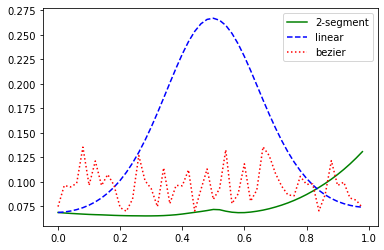

In [38]:
t = torch.Tensor(np.arange(0,1,0.02))
plt.plot(t,res,'g',label='2-segment')
plt.plot(t,res_lin,'b--',label='linear')
plt.plot(t,res_bez,'r:',label='bezier')
plt.legend(loc='best')
plt.savefig("losses3Methods.jpg")